In [89]:
import warnings
warnings.filterwarnings('ignore')
import csv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import scipy.stats
import random
import seaborn as sns

In [90]:
csv_data_pandas = pd.read_csv("/sciclone/home2/geogdan/Project_2/project_2_GISjoin.csv", delimiter=",")

#FromQGIS, we know the State ID of Virginia is 51, so we'll only pull those counties.
csv_data_pandas = csv_data_pandas.loc[csv_data_pandas['STATEFP'] == 51]

subset_dta = csv_data_pandas[['nhgis0012_ds215_20155_2015_county_ADNKE001','nhgis0012_ds215_20155_2015_county_ADNKM001','NUMPOINTS']]

print(subset_dta)

      nhgis0012_ds215_20155_2015_county_ADNKE001  \
2820                                     39412.0   
2821                                     68449.0   
2822                                     45007.0   
2823                                     56850.0   
2824                                     47558.0   
2825                                     48823.0   
2826                                    105763.0   
2827                                     54558.0   
2828                                     43646.0   
2829                                     56316.0   
2830                                     45294.0   
2831                                     60454.0   
2832                                     36919.0   
2833                                     29679.0   
2834                                     40331.0   
2835                                     47699.0   
2836                                     59227.0   
2837                                     35000.0   
2838        

0.000475839544313


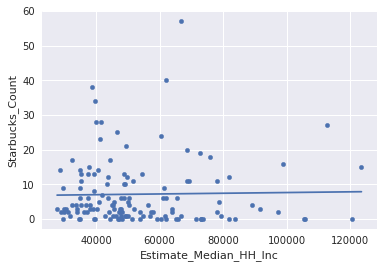

In [92]:
subset_dta.columns=['Estimate_Median_HH_Inc','Error_Margins', 'Starbucks_Count']


subset_dta.plot.scatter(x="Estimate_Median_HH_Inc",y="Starbucks_Count")
plt.plot(np.unique(subset_dta["Estimate_Median_HH_Inc"]), np.poly1d(np.polyfit(subset_dta["Estimate_Median_HH_Inc"], subset_dta["Starbucks_Count"], 1))(np.unique(subset_dta["Estimate_Median_HH_Inc"])))
plt.figure()
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(subset_dta['Estimate_Median_HH_Inc'], subset_dta['Starbucks_Count'])
print(r_value**2)

0.0206336190239


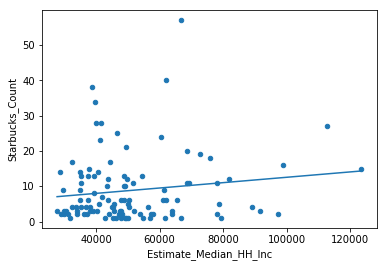

In [26]:
at_least_one_SB = subset_dta.loc[subset_dta['Starbucks_Count'] > 0]


at_least_one_SB.plot.scatter(x="Estimate_Median_HH_Inc",y="Starbucks_Count")
plt.plot(np.unique(at_least_one_SB["Estimate_Median_HH_Inc"]), np.poly1d(np.polyfit(at_least_one_SB["Estimate_Median_HH_Inc"], at_least_one_SB["Starbucks_Count"], 1))(np.unique(at_least_one_SB["Estimate_Median_HH_Inc"])))
plt.figure()
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(at_least_one_SB['Estimate_Median_HH_Inc'], at_least_one_SB['Starbucks_Count'])
print(r_value**2)

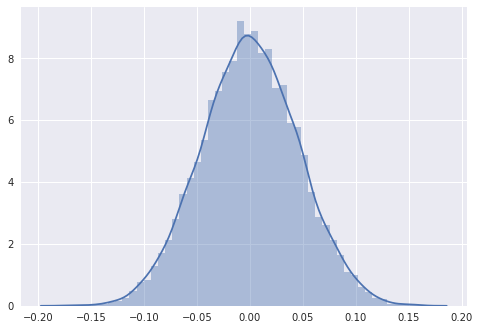

In [65]:
#We want to introduce two types of possible simulated errors
#On one hand, we know the census data has error (moving left to right on the scatterplot)
#On the other hand, we hypothesize that our Starbucks google maps scrape may have errors.

#First, let's simulate our known errors.
#The Census uses 90% confidence intervals, so 90% of the time the "true" value
#will fall within +/- 10% of the error they gave us.

#We need to build a distribution that can replicate this.  There are many choices,
#but the confidence intervals the census uses are largely predicated upon beta distributional
#assumptions.  I.e.:

est_hh_inc = 10000
margin_of_error = 1000

#In this example, 90% of the time we want values that fall between 9000 and 11000 (10% error).

#We can create a distribution that approximates this following:
beta_ex = np.random.beta(50,50,size=10000)-0.5
sns.distplot(beta_ex)



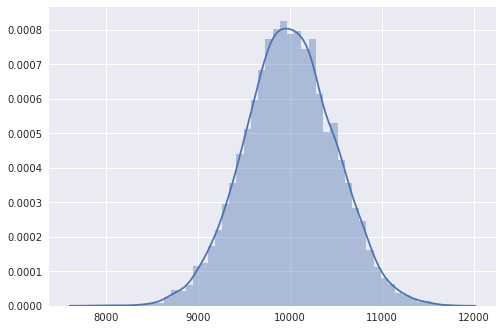

In [42]:
#and then simulate for this example what the distribution of values is likely to be:
est_hh_inc = ((np.random.beta(50,50,size=10000)-0.5) * 10000) + 10000
sns.distplot(est_hh_inc)

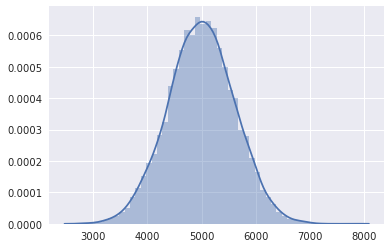

In [94]:
#We can also solve this with a beta distribution.
#By definition, in a beta distribution, 90% of values fall within 1.645 standard deviations.
#So, we calculate a standard deviation by:

#10,000
#1,000 error

#5,000
#1,000

sd = 0.2 / 1.645
rand_norm_examp = (np.random.normal(0, sd, 10000) * 5000) + 5000
sns.distplot(rand_norm_examp)

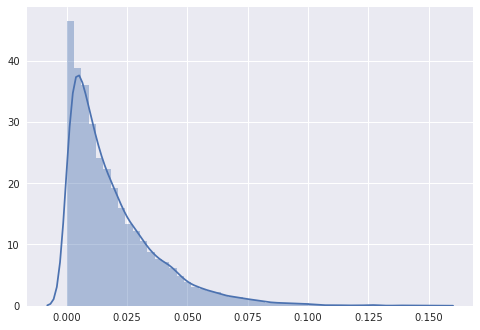

In [55]:
#We want to do something similar for stabucks locations.
#Here, I'm going to assume we undercounted by up to (approx) 10 in each
#county, with a decreasing likelihood as we approach larger
#miscounts.

sb_distribution = np.random.beta(1,50,size=10000)
sns.distplot(sb_distribution)

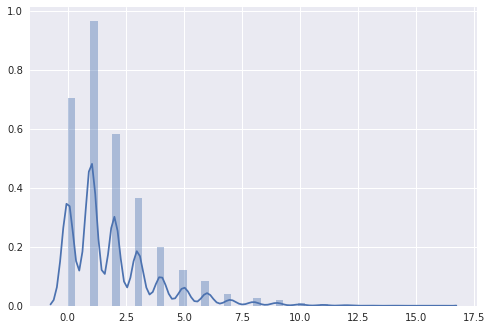

In [63]:
sb_counts_err = np.random.beta(1,50,size=10000) * 100
sb_counts_err = sb_counts_err.round(decimals=0)

sns.distplot(sb_counts_err)

In [88]:
#Let's follow these steps with the real data, now:
sim_dta = subset_dta



    
    #Note we're using 1.645 in the below equation to approximate
    #a 10% confidence interval.  
    
ratio_est = sim_dta['Error_Margins'] / sim_dta['Estimate_Median_HH_Inc']
sd = ratio_est / 1.645
simulated_est_hh_inc = (np.random.normal(0, sd, 10000) * sim_dta['Estimate_Median_HH_Inc'].item()) + sim_dta['Estimate_Median_HH_Inc']
    

print(simulated_est_hh_inc)



KeyError: ('Error_Margins', 1)